## Notebook Vae kaggle

In [ ]:
!pip install -r ../requirements.txt

In [3]:
from torch import nn, optim
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time
import kagglehub

/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import utils
import dataloader

In [ ]:

#from sklearn.datasets import fetch_olivetti_faces
#data = fetch_olivetti_faces(shuffle=True, random_state=42)
#images = data.images  # Images de taille (64, 64)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/e20210000275/scikit_learn_data


In [5]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

for root, dirs, files in os.walk(path):
    print(f"Dossier: {root}")
    print(f"Sous-dossiers: {dirs}")
    print(f"Fichiers (premiers 5): {files[:5]}")
    break

100%|██████████| 1.33G/1.33G [00:45<00:00, 31.2MB/s]

Extracting files...


Path to dataset files: /home/e20210000275/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2
Dossier: /home/e20210000275/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2
Sous-dossiers: ['img_align_celeba']
Fichiers (premiers 5): ['list_attr_celeba.csv', 'list_bbox_celeba.csv', 'list_eval_partition.csv', 'list_landmarks_align_celeba.csv']


In [6]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


In [66]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
import random

# Définir les transformations pour redimensionner les images à 64x64
transform = Compose([
    Resize((64, 64)),  # Redimensionner les images à 64x64
    ToTensor(),        # Convertir en tenseur PyTorch
    Normalize((0.5,), (0.5,))  # Normaliser les pixels entre -1 et 1
])

# Charger le dataset complet
dataset_path = "/home/e20210000275/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2"
human_faces_dataset = ImageFolder(root=dataset_path, transform=transform)

# Réduire à 10% du dataset
dataset_size = len(human_faces_dataset)
subset_size = int(0.1 * dataset_size)
indices = random.sample(range(dataset_size), subset_size)
subset_dataset = Subset(human_faces_dataset, indices)

# Diviser le sous-dataset en train/test
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Nombre d'images dans le sous-dataset : {len(subset_dataset)}")
print(f"Nombre d'images dans le train set : {len(train_dataset)}")
print(f"Nombre d'images dans le test set : {len(test_dataset)}")

Nombre d'images dans le sous-dataset : 20259
Nombre d'images dans le train set : 16207
Nombre d'images dans le test set : 4052


In [67]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))

In [68]:
EMBEDDING_SIZE = 128

class VAE(nn.Module):
    def __init__(self, embedding=128):
        super().__init__()
        self.embedding = embedding
        self.max_feature = 16
        self.img_size = 64

        # Définir l'encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Calculer la taille aplatie après l'encodeur
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, self.img_size, self.img_size)
            dummy_output = self.encoder(dummy_input)
            self.flattened_size = dummy_output.numel()

        # Définir les couches restantes
        self.fc_decode = nn.Linear(self.embedding, self.flattened_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

        self.fc_mu = nn.Linear(self.flattened_size, self.embedding)
        self.fc_logvar = nn.Linear(self.flattened_size, self.embedding)

    def encode(self, x):
        encoded = self.encoder(x)
        #print(f"Taille après encodeur : {encoded.shape}")
        f = torch.flatten(encoded,1)
        mean = self.fc_mu(f)
        logvar = self.fc_logvar(f)
        return mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean

    def forward(self, x):
        mean, logvar = self.encode(x)
        #print(f"Mean shape: {mean.shape}, Logvar shape: {logvar.shape}")  # Vérifiez les dimensions

        z = self.reparametrize(mean, logvar)
        h = self.fc_decode(z)
        h = h.view(-1, self.max_feature, self.img_size // 4, self.img_size // 4)  # Ajustez ici si nécessaire
        res = self.decoder(h)
        return z, res, mean, logvar
    
    def random(self):

        z = torch.randn((1, self.embedding), device=next(self.parameters()).device)

        h = self.fc_decode(z)

        h = h.view(-1, self.max_feature, self.img_size, self.img_size)

        res = self.decoder(h)
        return z, res

In [69]:
autoencoder = VAE(embedding=256).to(device)

final_classifier_loss = [0.0,0.0]
losses = []

L1loss = nn.L1Loss()
lpipsLoss = lpips.LPIPS(net='alex').to(device)
lpips_factor = 0.1

optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"VAE has {params} parameters")

beta = 2.0

def elbo_loss(recon, x, mean, logvar):
    lpi_loss = lpipsLoss(recon, x).mean() * lpips_factor 
    recon_loss = F.l1_loss(recon, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + lpi_loss + beta * kl_loss, recon_loss, beta * kl_loss

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
VAE has 3154219 parameters


In [84]:
epochs = 60
eta = ETA(epochs)

for epoch in range(epochs):
    eta.update()
    eta.print()
    total_loss = 0.0
    autoencoder.train()

    for images, labels in train_loader:
        # Vérifiez que les images sont des tenseurs PyTorch
        if isinstance(images, np.ndarray):
            images = torch.tensor(images, dtype=torch.float32)

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        z, recon, mean, logvar = autoencoder(images)

        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    autoencoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        if isinstance(images, np.ndarray):
            images = torch.tensor(images, dtype=torch.float32)

        images = images.to(device)
        labels = labels.to(device)

        z, recon, mean, logvar = autoencoder(images)
        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)

        total_eval_loss += loss.item()

    scheduler.step()

    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss

    if (epoch + 1) % 50 == 0:
        # torch.save(autoencoder.state_dict(), f"models/autoencoder_epoch_{epoch+1}.pth")
        pass

0s
Epoch 1, training loss: 2465.8962, test loss: 2414.4239
1h 48m 25s
Epoch 2, training loss: 2373.3997, test loss: 2455.6608
1h 34m 44s
Epoch 3, training loss: 2322.9253, test loss: 2294.1904
1h 25m 33s
Epoch 4, training loss: 2266.1520, test loss: 2214.1759
1h 18m 43s
Epoch 5, training loss: 2201.6393, test loss: 2211.5467
1h 12m 56s
Epoch 6, training loss: 2161.0557, test loss: 2121.5421
1h 7m 59s
Epoch 7, training loss: 2128.1068, test loss: 2148.1790
1h 4m 12s
Epoch 8, training loss: 2107.1769, test loss: 2069.5415
1h 1m 48s
Epoch 9, training loss: 2092.7003, test loss: 2038.8207
59m 0s
Epoch 10, training loss: 2065.4567, test loss: 2042.7847
56m 22s
Epoch 11, training loss: 2045.5448, test loss: 2008.0362
54m 12s
Epoch 12, training loss: 2027.8551, test loss: 2041.8880
52m 6s
Epoch 13, training loss: 2013.1395, test loss: 1984.9169
50m 16s
Epoch 14, training loss: 1999.2673, test loss: 2001.8634
48m 26s
Epoch 15, training loss: 1989.9097, test loss: 1963.9865
47m 4s
Epoch 16, tra

In [85]:
torch.save(autoencoder.state_dict(), "models/autoencoder_on_celebA_60epochs.pth")

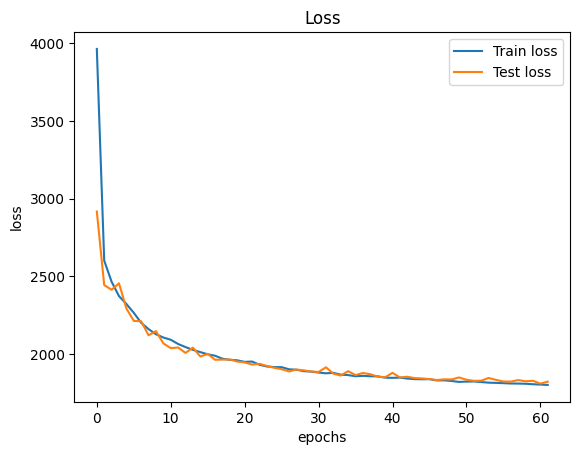

In [86]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

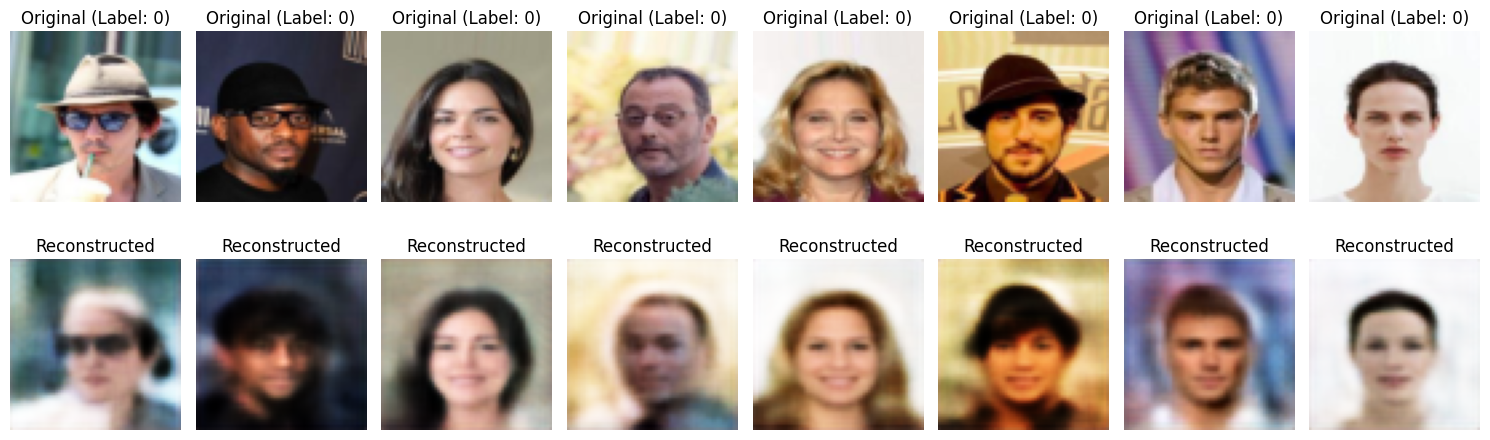

In [87]:
autoencoder.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():

    _,reconstructed_images, _,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

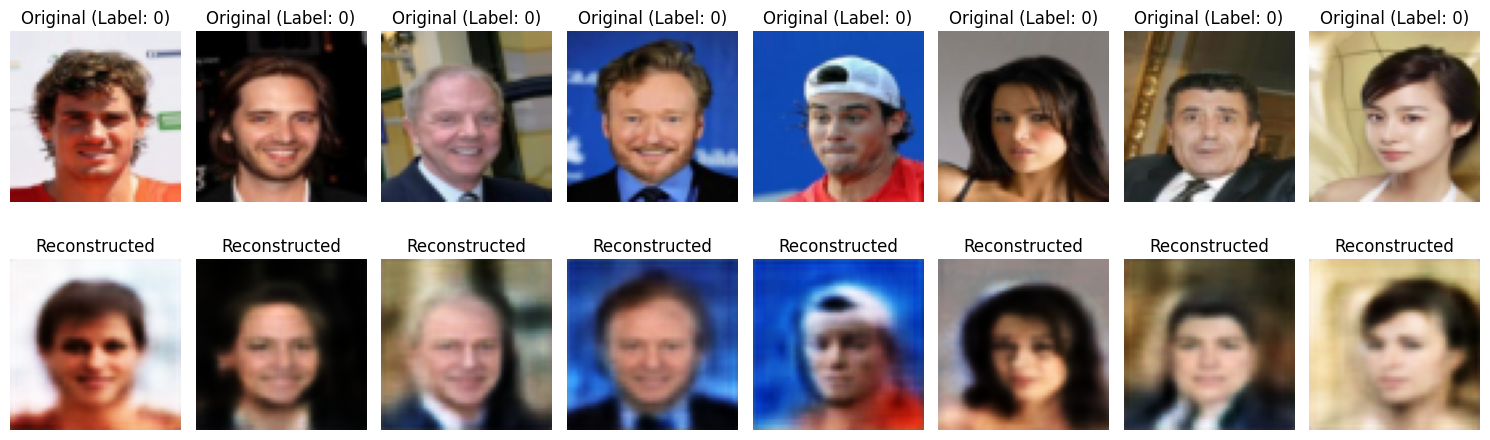

In [88]:
autoencoder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    _,reconstructed_images,_,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

# fine tunig

Charger les images personelles :

In [89]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, Grayscale
from torch.utils.data import DataLoader

# Définir les transformations pour vos images personnelles
personal_transform = Compose([
    Resize((64, 64)),  # Assurez-vous que la taille correspond à celle utilisée dans le modèle
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Charger les données personnelles
personal_dataset = ImageFolder(root="../data/Face-Swap-M2-Dataset/dataset/smaller/", transform=personal_transform)

# Diviser en train/test
train_size = int(0.8 * len(personal_dataset))
test_size = len(personal_dataset) - train_size
personal_train_dataset, personal_test_dataset = torch.utils.data.random_split(personal_dataset, [train_size, test_size])

# Créer les DataLoaders
personal_train_loader = DataLoader(personal_train_dataset, batch_size=16, shuffle=True)
personal_test_loader = DataLoader(personal_test_dataset, batch_size=16, shuffle=False)

print(f"Nombre d'images dans le dataset personnel : {len(personal_dataset)}")
print(f"Nombre de classes (personnes) : {len(personal_dataset.classes)}")

Nombre d'images dans le dataset personnel : 89
Nombre de classes (personnes) : 10


In [90]:
# Charger les poids du modèle pré-entraîné
autoencoder.load_state_dict(torch.load("models/autoencoder_on_celebA_60epochs.pth"))
autoencoder.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_decode): Linear(in_features=256, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Tanh()
  )
  (fc_mu): Linear(in_features=4096, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=256, bias=True)
)

boucle d'entraînement pour le fine-tuning :

In [96]:
autoencoder.train()

# Définir un nouvel optimiseur avec un taux d'apprentissage plus faible
fine_tune_optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)

# Fine-tuning sur les données personnelles
fine_tune_epochs = 500
for epoch in range(fine_tune_epochs):
    total_loss = 0.0
    for images, _ in personal_train_loader:  # Les labels ne sont pas nécessaires pour un VAE
        images = images.to(device)

        fine_tune_optimizer.zero_grad()

        # Passer les images dans le modèle
        z, recon, mean, logvar = autoencoder(images)

        # Calculer la perte
        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)
        loss.backward()
        fine_tune_optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{fine_tune_epochs}, Loss: {total_loss / len(personal_train_loader):.4f}")

Epoch 1/500, Loss: 3033.2013
Epoch 2/500, Loss: 2574.6581
Epoch 3/500, Loss: 2544.1192
Epoch 4/500, Loss: 2422.3947
Epoch 5/500, Loss: 2385.5864
Epoch 6/500, Loss: 2385.1779
Epoch 7/500, Loss: 2348.2139
Epoch 8/500, Loss: 2387.3348
Epoch 9/500, Loss: 2344.3922
Epoch 10/500, Loss: 2288.9162
Epoch 11/500, Loss: 2248.9748
Epoch 12/500, Loss: 2305.4289
Epoch 13/500, Loss: 2275.0091
Epoch 14/500, Loss: 2205.5314
Epoch 15/500, Loss: 2184.4152
Epoch 16/500, Loss: 2200.8261
Epoch 17/500, Loss: 2173.4442
Epoch 18/500, Loss: 2129.5933
Epoch 19/500, Loss: 2154.9367
Epoch 20/500, Loss: 2215.9029
Epoch 21/500, Loss: 2138.4135
Epoch 22/500, Loss: 2116.1133
Epoch 23/500, Loss: 2125.2280
Epoch 24/500, Loss: 2118.7515
Epoch 25/500, Loss: 2125.2553
Epoch 26/500, Loss: 2126.0125
Epoch 27/500, Loss: 2079.3745
Epoch 28/500, Loss: 2067.2255
Epoch 29/500, Loss: 2096.7582
Epoch 30/500, Loss: 2113.6465
Epoch 31/500, Loss: 2042.6197
Epoch 32/500, Loss: 2053.8663
Epoch 33/500, Loss: 2066.5298
Epoch 34/500, Loss:

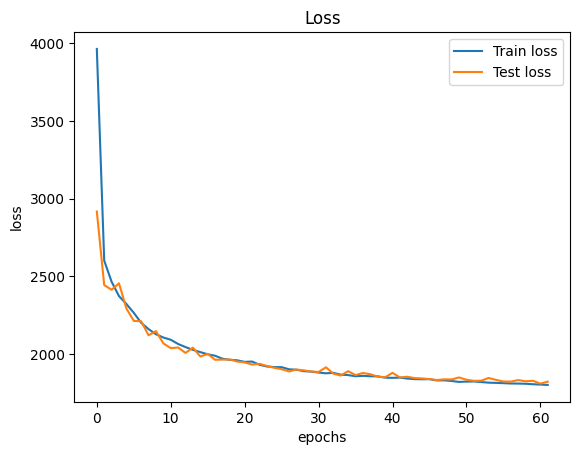

In [92]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

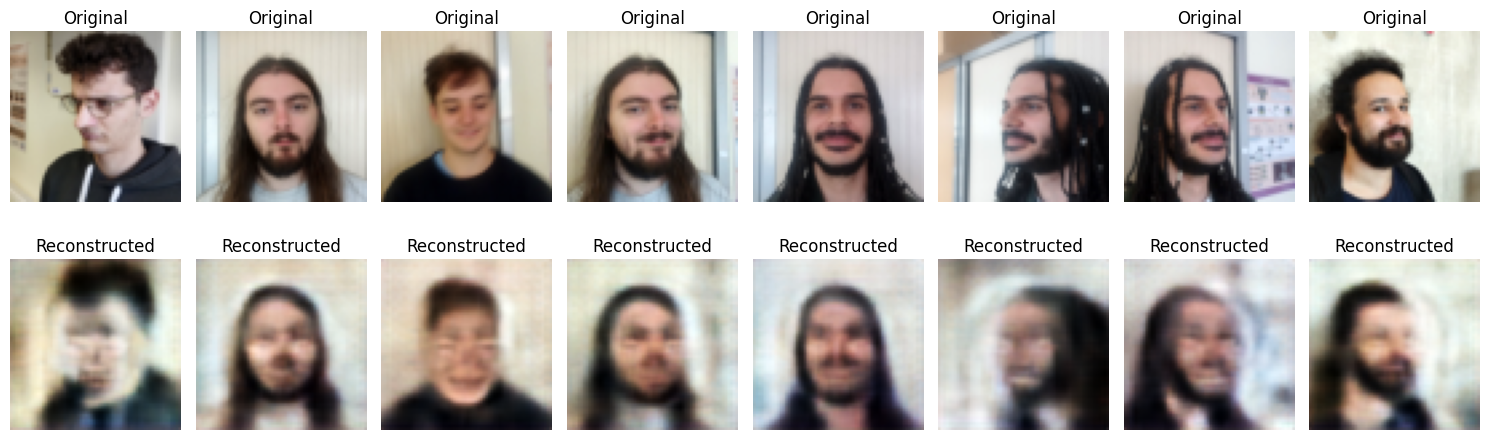

In [94]:
autoencoder.eval()

images, _ = next(iter(personal_test_loader))
images = images.to(device)

with torch.no_grad():
    _, reconstructed_images, _, _ = autoencoder(images)

n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    # Image originale
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    axs[0, i].imshow(img)
    axs[0, i].set_title("Original")
    axs[0, i].axis("off")

    # Image reconstruite
    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    recon_img = (recon_img - recon_img.min()) / (recon_img.max() - recon_img.min())
    axs[1, i].imshow(recon_img)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

torch.save(autoencoder.state_dict(), "models/fine_tuned_autoencoder.pth")

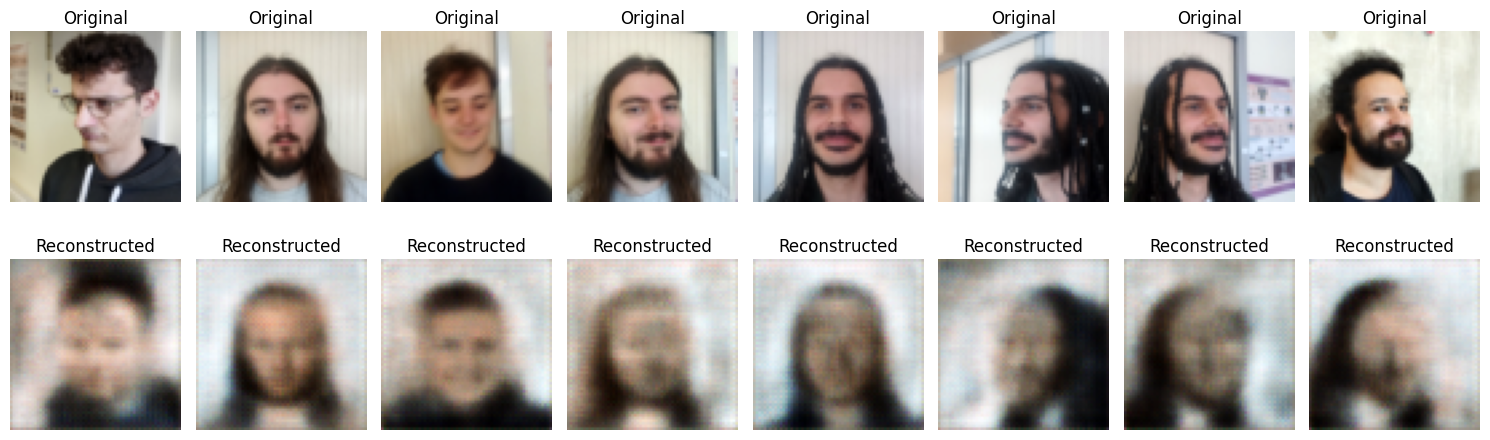

In [95]:
autoencoder.load_state_dict(torch.load("models/autoencoder_on_celebA_1epochs.pth"))
autoencoder.eval()

images, _ = next(iter(personal_test_loader))
images = images.to(device)

with torch.no_grad():
    _, reconstructed_images, _, _ = autoencoder(images)

n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    # Image originale
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    axs[0, i].imshow(img)
    axs[0, i].set_title("Original")
    axs[0, i].axis("off")

    # Image reconstruite
    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    recon_img = (recon_img - recon_img.min()) / (recon_img.max() - recon_img.min())
    axs[1, i].imshow(recon_img)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

